In [1]:
# Weather Dashboard Using Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Display settings
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda v: f"{v:,.3f}")

In [3]:
#DATA_PATH = Path("Weather_EDA_V2.0.csv")

In [4]:
raw_df = pd.read_csv(r"E:\R3SPAnalytics\00 IIT KGP Hyd\000-R3SPAI\Engagements\ESCI-AIML-Hyderabad\Weather_EDA_V2.0.csv", header=0)

print("Raw shape:", raw_df.shape)
raw_df.head()

Raw shape: (16639, 27)


,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month_D,Year_D,Day_D,WeekNum_D
0,1-Jan-1980,9.500,29.200,0.100,5.600,12.400,NW,38.700,W,SSE,23.800,16.300,22,65,"1,022.200","1,011.000",7,6,14.700,17.700,No,0.000,No,Jan,1980,Tue,1
1,2-Jan-1980,13.800,35.100,0.800,3.700,10.600,S,56.900,S,N,17.400,8.000,22,26,"1,007.100",996.900,8,6,18.400,22.300,Yes,0.800,Yes,Jan,1980,Wed,1
2,3-Jan-1980,8.000,18.200,0.100,6.400,7.500,NNW,49.000,SW,NNE,12.900,15.900,63,81,"1,015.100","1,012.400",3,1,19.300,17.700,Yes,0.600,Yes,Jan,1980,Thu,1
3,4-Jan-1980,13.100,13.700,2.800,4.500,9.500,WNW,23.700,ESE,N,16.400,22.800,67,42,"1,018.400","1,011.600",2,8,14.700,18.000,No,0.500,Yes,Jan,1980,Fri,1
4,5-Jan-1980,12.500,24.000,3.800,3.300,8.100,N,49.600,W,W,7.300,8.200,23,33,"1,012.900","1,008.300",4,8,8.200,18.000,Yes,5.000,Yes,Jan,1980,Sat,1


In [5]:
df = raw_df.copy()

In [6]:
# ---- Date handling ----
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Date')
df['Year']      = df['Date'].dt.year
df['Month']     = df['Date'].dt.month
df['MonthName'] = df['Date'].dt.month_name()
df['Day']       = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.day_name()
df['WeekNum']   = df['Date'].dt.isocalendar().week

# Standard meteorological seasons (Northern Hemisphere)
season_map = {12:'Winter',1:'Winter',2:'Winter',
              3:'Spring',4:'Spring',5:'Spring',
              6:'Summer',7:'Summer',8:'Summer',
              9:'Autumn',10:'Autumn',11:'Autumn'}
df['Season'] = df['Month'].map(season_map)

# Flags
df['IsRainy']   = df['Rainfall'] > 0
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday','Sunday'])

# Core derived metrics
df['AvgTemp']           = (df['MinTemp'] + df['MaxTemp']) / 2
df['AvgHumidity']       = (df['Humidity9am'] + df['Humidity3pm']) / 2
df['HumidityVariation'] = (df['Humidity3pm'] - df['Humidity9am']).abs()

# Temperature Stability Index (TSI)
denom = (df['MaxTemp'].abs() + df['MinTemp'].abs())
df['TSI'] = 1 - (df['MaxTemp'] - df['MinTemp']).abs() / denom.replace(0, np.nan)
df['TSI'] = df['TSI'].clip(0, 1)

# Average Wind Speed (if available)
if {'WindSpeed9am','WindSpeed3pm'}.issubset(df.columns):
    df['AvgWindSpeed'] = df[['WindSpeed9am','WindSpeed3pm']].mean(axis=1)
elif 'WindSpeed3pm' in df.columns:
    df['AvgWindSpeed'] = df['WindSpeed3pm']
elif 'WindSpeed9am' in df.columns:
    df['AvgWindSpeed'] = df['WindSpeed9am']
else:
    df['AvgWindSpeed'] = np.nan

# Rolling metrics (window = 7 days)
df['AvgTemp_7d']  = df['AvgTemp'].rolling(7, min_periods=3).mean()
df['Rain_7d_Sum'] = df['Rainfall'].rolling(7, min_periods=3).sum()

print("Enriched shape:", df.shape)
df.head()

Enriched shape: (16639, 43)


,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month_D,Year_D,Day_D,WeekNum_D,Year,Month,MonthName,Day,DayOfWeek,WeekNum,Season,IsRainy,IsWeekend,AvgTemp,AvgHumidity,HumidityVariation,TSI,AvgWindSpeed,AvgTemp_7d,Rain_7d_Sum
0,1980-01-01,9.500,29.200,0.100,5.600,12.400,NW,38.700,W,SSE,23.800,16.300,22,65,"1,022.200","1,011.000",7,6,14.700,17.700,No,0.000,No,Jan,1980,Tue,1,1980,1,January,1,Tuesday,1,Winter,True,False,19.350,43.500,43,0.491,20.050,NaN,NaN
1,1980-01-02,13.800,35.100,0.800,3.700,10.600,S,56.900,S,N,17.400,8.000,22,26,"1,007.100",996.900,8,6,18.400,22.300,Yes,0.800,Yes,Jan,1980,Wed,1,1980,1,January,2,Wednesday,1,Winter,True,False,24.450,24.000,4,0.564,12.700,NaN,NaN
2,1980-01-03,8.000,18.200,0.100,6.400,7.500,NNW,49.000,SW,NNE,12.900,15.900,63,81,"1,015.100","1,012.400",3,1,19.300,17.700,Yes,0.600,Yes,Jan,1980,Thu,1,1980,1,January,3,Thursday,1,Winter,True,False,13.100,72.000,18,0.611,14.400,18.967,1.000
3,1980-01-04,13.100,13.700,2.800,4.500,9.500,WNW,23.700,ESE,N,16.400,22.800,67,42,"1,018.400","1,011.600",2,8,14.700,18.000,No,0.500,Yes,Jan,1980,Fri,1,1980,1,January,4,Friday,1,Winter,True,False,13.400,54.500,25,0.978,19.600,17.575,3.800
4,1980-01-05,12.500,24.000,3.800,3.300,8.100,N,49.600,W,W,7.300,8.200,23,33,"1,012.900","1,008.300",4,8,8.200,18.000,Yes,5.000,Yes,Jan,1980,Sat,1,1980,1,January,5,Saturday,1,Winter,True,True,18.250,28.000,10,0.685,7.750,17.710,7.600


In [7]:
#df.isnull().sum()

In [23]:
#Write the file EDA_Weather_Analysis_V1.0
#df.to_csv("E://ESCIHyd//Data//Weather_File01.csv")

### Aggregation Functions

In [8]:
def aggregate_by_week(data: pd.DataFrame) -> pd.DataFrame:
    g = (data.groupby(['Year','WeekNum'])
              .agg(MinTemp=('MinTemp','min'),
                   MaxTemp=('MaxTemp','max'),
                   AvgTemp=('AvgTemp','mean'),
                   Rainfall=('Rainfall','sum'),
                   RainfallPerDay=('Rainfall','mean'),
                   AvgHumidity=('AvgHumidity','mean'),
                   HumidityVar=('HumidityVariation','mean'),
                   TSI=('TSI','mean'),
                   AvgWindSpeed=('AvgWindSpeed','mean'),
                   RainyDays=('IsRainy','sum'),
                   TotalDays=('IsRainy','count'),
                   StartDate=('Date','min')))
    g['RainyDayPct'] = 100 * g['RainyDays'] / g['TotalDays']
    return g.reset_index()

def aggregate_by_month(data: pd.DataFrame) -> pd.DataFrame:
    g = (data.groupby(['Year','Month'])
              .agg(MinTemp=('MinTemp','min'),
                   MaxTemp=('MaxTemp','max'),
                   AvgTemp=('AvgTemp','mean'),
                   Rainfall=('Rainfall','sum'),
                   RainfallPerDay=('Rainfall','mean'),
                   AvgHumidity=('AvgHumidity','mean'),
                   HumidityVar=('HumidityVariation','mean'),
                   TSI=('TSI','mean'),
                   AvgWindSpeed=('AvgWindSpeed','mean'),
                   RainyDays=('IsRainy','sum'),
                   TotalDays=('IsRainy','count'),
                   StartDate=('Date','min')))
    g['RainyDayPct'] = 100 * g['RainyDays'] / g['TotalDays']
    g['MonthYear'] = g['StartDate'].dt.strftime('%b %Y')
    return g.reset_index()

def aggregate_by_season(data: pd.DataFrame) -> pd.DataFrame:
    g = (data.groupby(['Year','Season'])
              .agg(AvgTemp=('AvgTemp','mean'),
                   Rainfall=('Rainfall','sum'),
                   RainfallPerDay=('Rainfall','mean'),
                   AvgHumidity=('AvgHumidity','mean'),
                   HumidityVar=('HumidityVariation','mean'),
                   TSI=('TSI','mean'),
                   AvgWindSpeed=('AvgWindSpeed','mean'),
                   RainyDays=('IsRainy','sum'),
                   TotalDays=('IsRainy','count')))
    g['RainyDayPct'] = 100 * g['RainyDays'] / g['TotalDays']
    return g.reset_index()

def aggregate_by_dayofweek(data: pd.DataFrame) -> pd.DataFrame:
    g = (data.groupby('DayOfWeek')
              .agg(AvgTemp=('AvgTemp','mean'),
                   HumidityVar=('HumidityVariation','mean'),
                   AvgWindSpeed=('AvgWindSpeed','mean'),
                   Rainfall=('Rainfall','mean'),
                   RainyDayPct=('IsRainy','mean')))
    g['RainyDayPct'] *= 100
    # Order logically
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    g = g.reindex(order)
    return g.reset_index()

### KPI Computation Helpers

In [9]:
def compute_global_kpis(data: pd.DataFrame) -> dict:
    """
    Returns dictionary of the key KPI scalar values on the provided data subset.
    """
    n_days = len(data)
    rainy_days = data['IsRainy'].sum()
    kpis = {
        "AverageTemperature_C": data['AvgTemp'].mean(),
        "RainfallIntensity_mm_per_day": data['Rainfall'].sum() / n_days if n_days else np.nan,
        "HumidityVariation_avg_pct_points": data['HumidityVariation'].mean(),
        "TemperatureStabilityIndex_mean": data['TSI'].mean(),
        "WindSpeedTrend_mean_kmh": data['AvgWindSpeed'].mean(),
        "RainyDayPercent": (rainy_days / n_days * 100) if n_days else np.nan
    }
    return kpis

# Example on entire dataset:
global_kpis = compute_global_kpis(df)
pd.DataFrame(global_kpis, index=["All Data"])

,AverageTemperature_C,RainfallIntensity_mm_per_day,HumidityVariation_avg_pct_points,TemperatureStabilityIndex_mean,WindSpeedTrend_mean_kmh,RainyDayPercent
All Data,17.950,3.535,26.587,0.644,16.038,98.630


### Rolling & Spell Metric Functions

In [10]:
def longest_consecutive(mask: pd.Series) -> int:
    run = max_run = 0
    for v in mask:
        if v:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run

def compute_spell_metrics(data: pd.DataFrame) -> dict:
    dry = (data['Rainfall'] == 0)
    wet = (data['Rainfall'] > 0)
    return {
        "LongestDrySpell_days": longest_consecutive(dry),
        "LongestWetSpell_days": longest_consecutive(wet)
    }

spell_metrics_all = compute_spell_metrics(df)
spell_metrics_all

{'LongestDrySpell_days': 2, 'LongestWetSpell_days': 368}

In [11]:
weekly_df   = aggregate_by_week(df)
monthly_df  = aggregate_by_month(df)
seasonal_df = aggregate_by_season(df)
dow_df      = aggregate_by_dayofweek(df)

weekly_df.head(), monthly_df.head(), seasonal_df.head(), dow_df.head()

(   Year  WeekNum  MinTemp  MaxTemp  AvgTemp  Rainfall  RainfallPerDay  \
 0  1980        1    8.000   35.100   18.767    14.300           1.589   
 1  1980        2    5.700   26.000   16.686    32.600           4.657   
 2  1980        3    1.900   33.300   15.621    29.900           4.271   
 3  1980        4    2.600   31.800   17.029    32.000           4.571   
 4  1980        5    3.400   24.900   15.479    14.800           2.114   
 
    AvgHumidity  HumidityVar   TSI  AvgWindSpeed  RainyDays  TotalDays  \
 0       53.333       16.000 0.671        14.528          9          9   
 1       58.643       31.571 0.712        16.236          7          7   
 2       47.286       25.429 0.526        15.871          7          7   
 3       61.214       34.143 0.686        16.336          7          7   
 4       66.357       23.000 0.545        16.014          7          7   
 
    StartDate  RainyDayPct  
 0 1980-01-01      100.000  
 1 1980-01-07      100.000  
 2 1980-01-14      10

In [12]:
kpi_df = pd.DataFrame(global_kpis, index=['All Data']).T
kpi_df.columns = ['Value']
kpi_df

,Value
AverageTemperature_C,17.950
RainfallIntensity_mm_per_day,3.535
HumidityVariation_avg_pct_points,26.587
TemperatureStabilityIndex_mean,0.644
WindSpeedTrend_mean_kmh,16.038
RainyDayPercent,98.630


In [13]:
print("=== Weekly Summary ===")
display(weekly_df.head(12))

print("=== Monthly Summary ===")
display(monthly_df.head(12))

print("=== Seasonal Summary ===")
display(seasonal_df)

print("=== Day-of-Week Summary ===")
display(dow_df)

=== Weekly Summary ===


,Year,WeekNum,MinTemp,MaxTemp,AvgTemp,Rainfall,RainfallPerDay,AvgHumidity,HumidityVar,TSI,AvgWindSpeed,RainyDays,TotalDays,StartDate,RainyDayPct
0,1980,1,8.000,35.100,18.767,14.300,1.589,53.333,16.000,0.671,14.528,9,9,1980-01-01,100.000
1,1980,2,5.700,26.000,16.686,32.600,4.657,58.643,31.571,0.712,16.236,7,7,1980-01-07,100.000
2,1980,3,1.900,33.300,15.621,29.900,4.271,47.286,25.429,0.526,15.871,7,7,1980-01-14,100.000
3,1980,4,2.600,31.800,17.029,32.000,4.571,61.214,34.143,0.686,16.336,7,7,1980-01-21,100.000
4,1980,5,3.400,24.900,15.479,14.800,2.114,66.357,23.000,0.545,16.014,7,7,1980-01-28,100.000
5,1980,6,6.500,27.400,16.579,11.100,1.586,71.929,13.571,0.616,15.300,7,7,1980-02-04,100.000
6,1980,7,5.200,31.000,15.993,15.600,2.229,48.143,20.857,0.621,13.993,7,7,1980-02-11,100.000
7,1980,8,3.100,37.100,17.900,21.600,3.086,54.571,29.429,0.494,15.443,7,7,1980-02-18,100.000
8,1980,9,4.600,32.000,20.414,19.900,2.843,56.143,25.429,0.611,16.486,7,7,1980-02-25,100.000
9,1980,10,5.100,30.400,15.293,34.000,4.857,73.857,18.571,0.633,15.793,7,7,1980-03-03,100.000


=== Monthly Summary ===


,Year,Month,MinTemp,MaxTemp,AvgTemp,Rainfall,RainfallPerDay,AvgHumidity,HumidityVar,TSI,AvgWindSpeed,RainyDays,TotalDays,StartDate,RainyDayPct,MonthYear
0,1980,1,1.900,35.100,16.542,108.600,3.503,55.919,26.677,0.629,16.176,31,31,1980-01-01,100.000,Jan 1980
1,1980,2,3.100,37.100,17.490,71.500,2.466,57.224,22.655,0.580,15.172,29,29,1980-02-01,100.000,Feb 1980
2,1980,3,3.500,30.600,16.550,125.000,4.032,64.016,20.484,0.659,15.518,31,31,1980-03-01,100.000,Mar 1980
3,1980,4,-1.600,38.700,18.358,93.700,3.123,61.900,25.667,0.591,16.620,30,30,1980-04-01,100.000,Apr 1980
4,1980,5,0.100,37.000,18.018,101.500,3.274,57.742,27.484,0.652,16.552,30,31,1980-05-01,96.774,May 1980
5,1980,6,1.700,39.700,17.580,138.700,4.623,63.583,20.900,0.627,16.435,30,30,1980-06-01,100.000,Jun 1980
6,1980,7,1.700,35.200,18.705,134.700,4.345,61.242,29.581,0.596,15.590,31,31,1980-07-01,100.000,Jul 1980
7,1980,8,3.400,38.800,17.577,85.400,2.755,59.355,27.548,0.620,16.774,31,31,1980-08-01,100.000,Aug 1980
8,1980,9,-0.700,33.500,17.088,113.100,3.770,61.533,30.400,0.630,15.928,29,30,1980-09-01,96.667,Sep 1980
9,1980,10,4.400,35.200,17.826,93.200,3.006,61.871,28.065,0.666,17.221,30,31,1980-10-01,96.774,Oct 1980


=== Seasonal Summary ===


,Year,Season,AvgTemp,Rainfall,RainfallPerDay,AvgHumidity,HumidityVar,TSI,AvgWindSpeed,RainyDays,TotalDays,RainyDayPct
0,1980,Autumn,17.427,310.100,3.408,62.956,27.275,0.651,16.627,89,91,97.802
1,1980,Spring,17.634,320.200,3.480,61.212,24.533,0.635,16.226,91,92,98.913
2,1980,Summer,17.958,358.800,3.900,61.370,26.065,0.614,16.265,92,92,100.000
3,1980,Winter,17.110,321.700,3.535,55.291,26.560,0.610,15.904,91,91,100.000
4,1981,Autumn,18.083,306.100,3.364,58.330,27.121,0.631,15.118,91,91,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...
178,2024,Summer,17.661,325.000,3.533,59.185,26.109,0.602,15.934,89,92,96.739
179,2024,Winter,18.170,371.400,4.081,61.181,28.429,0.688,15.831,91,91,100.000
180,2025,Spring,17.696,359.200,3.904,61.125,25.337,0.671,16.036,90,92,97.826
181,2025,Summer,17.982,188.700,3.700,62.000,28.902,0.656,16.126,48,51,94.118


=== Day-of-Week Summary ===


,DayOfWeek,AvgTemp,HumidityVar,AvgWindSpeed,Rainfall,RainyDayPct
0,Monday,17.915,26.538,15.908,3.486,98.948
1,Tuesday,17.832,27.026,16.152,3.382,98.275
2,Wednesday,17.976,27.189,16.060,3.576,98.864
3,Thursday,17.879,25.674,16.147,3.549,98.485
4,Friday,17.942,26.737,15.979,3.636,98.696
5,Saturday,18.036,26.642,15.986,3.587,98.612
6,Sunday,18.069,26.301,16.035,3.529,98.528


In [14]:
# Top 10 weeks by Rainfall Intensity
top_weeks_intensity = (weekly_df
                       .assign(RainIntensity=weekly_df['RainfallPerDay'])
                       .sort_values('RainIntensity', ascending=False)
                       .head(10))
display(top_weeks_intensity[['Year','WeekNum','Rainfall','RainfallPerDay','RainyDayPct']])

# Seasonal ranking by AvgTemp stability (higher TSI = more stable)
season_stability = seasonal_df.sort_values('TSI', ascending=False)
display(season_stability[['Year','Season','TSI','AvgTemp','RainyDayPct']])


,Year,WeekNum,Rainfall,RainfallPerDay,RainyDayPct
1159,2002,8,67.200,9.600,100.000
1768,2013,41,65.700,9.386,100.000
865,1996,28,65.400,9.343,100.000
1813,2014,34,64.800,9.257,100.000
2104,2020,11,62.500,8.929,85.714
2199,2021,53,26.200,8.733,100.000
2385,2025,30,8.700,8.700,100.000
50,1980,51,60.800,8.686,100.000
1262,2004,7,59.300,8.471,100.000
600,1991,25,59.000,8.429,100.000


,Year,Season,TSI,AvgTemp,RainyDayPct
44,1991,Autumn,0.697,18.420,100.000
26,1986,Summer,0.696,18.207,100.000
174,2023,Summer,0.695,18.218,100.000
179,2024,Winter,0.688,18.170,100.000
13,1983,Spring,0.685,17.746,100.000
...,...,...,...,...,...
178,2024,Summer,0.602,17.661,96.739
111,2007,Winter,0.598,17.128,96.667
6,1981,Summer,0.598,17.995,98.913
53,1993,Spring,0.593,17.357,98.913


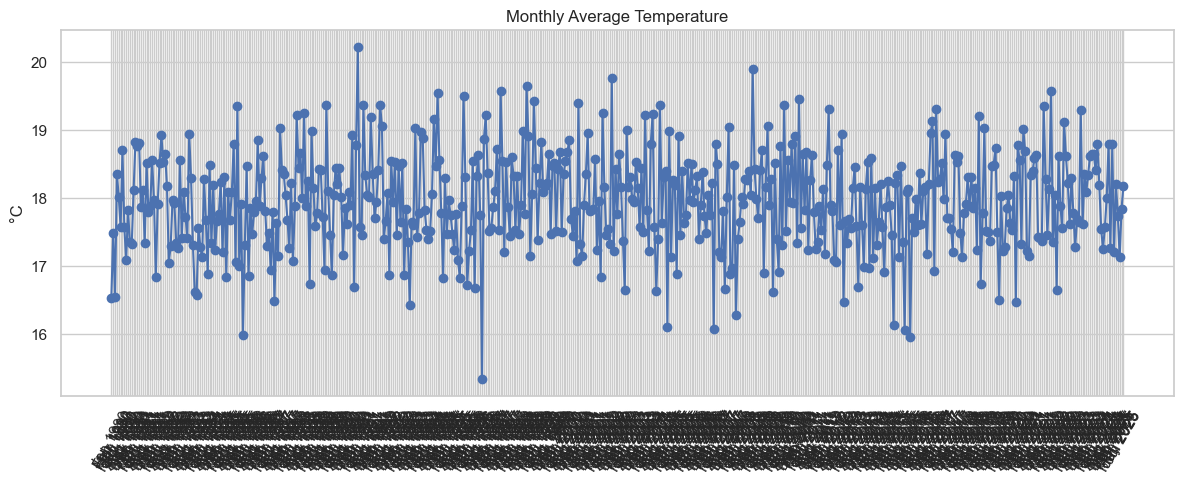

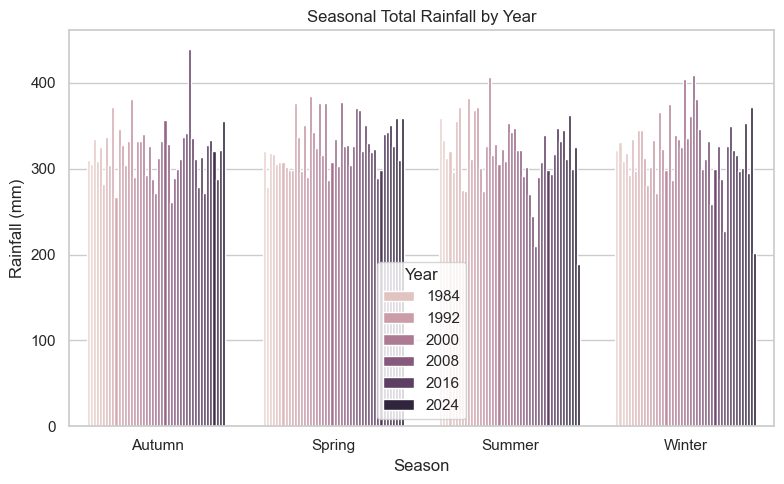

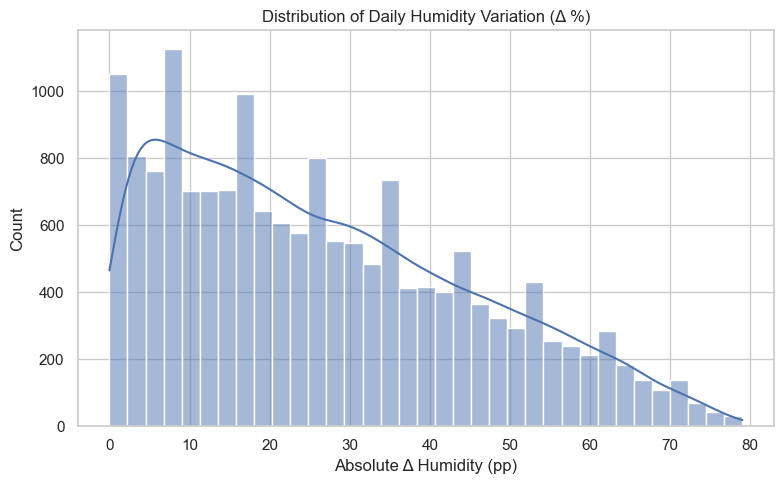

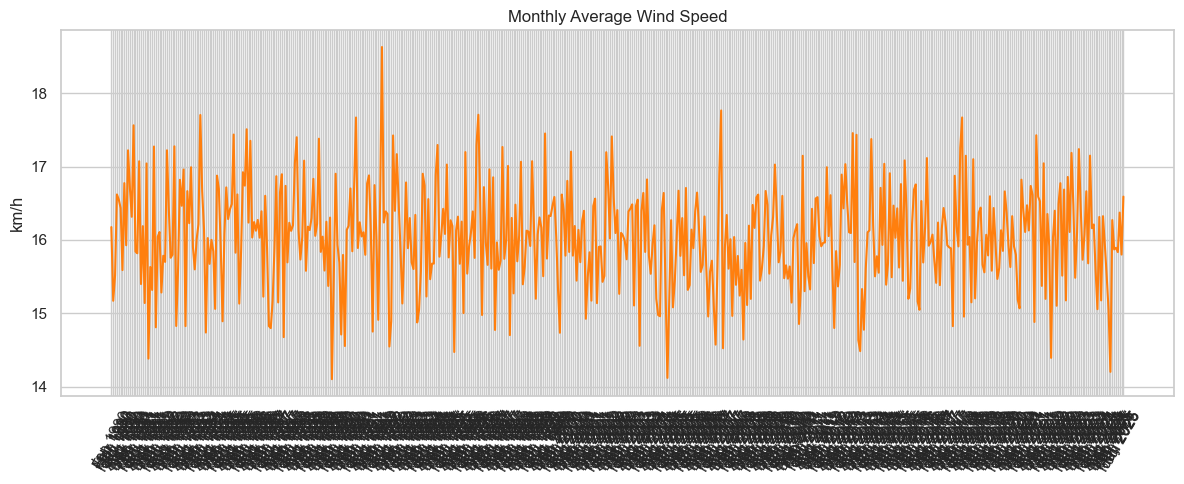

In [15]:
sns.set_theme(style="whitegrid")

# 1. Monthly AvgTemp line
plt.figure(figsize=(12,5))
plt.plot(monthly_df['MonthYear'], monthly_df['AvgTemp'], marker='o')
plt.xticks(rotation=60)
plt.title("Monthly Average Temperature")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

# 2. Seasonal Rainfall bar
plt.figure(figsize=(8,5))
sns.barplot(data=seasonal_df, x='Season', y='Rainfall', hue='Year')
plt.title("Seasonal Total Rainfall by Year")
plt.ylabel("Rainfall (mm)")
plt.tight_layout()
plt.show()

# 3. Humidity Variation distribution
plt.figure(figsize=(8,5))
sns.histplot(df['HumidityVariation'].dropna(), kde=True)
plt.title("Distribution of Daily Humidity Variation (Δ %)")
plt.xlabel("Absolute Δ Humidity (pp)")
plt.tight_layout()
plt.show()

# 4. Wind speed trend (monthly mean)
if 'AvgWindSpeed' in monthly_df:
    plt.figure(figsize=(12,5))
    plt.plot(monthly_df['MonthYear'], monthly_df['AvgWindSpeed'], color='tab:orange')
    plt.title("Monthly Average Wind Speed")
    plt.ylabel("km/h")
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

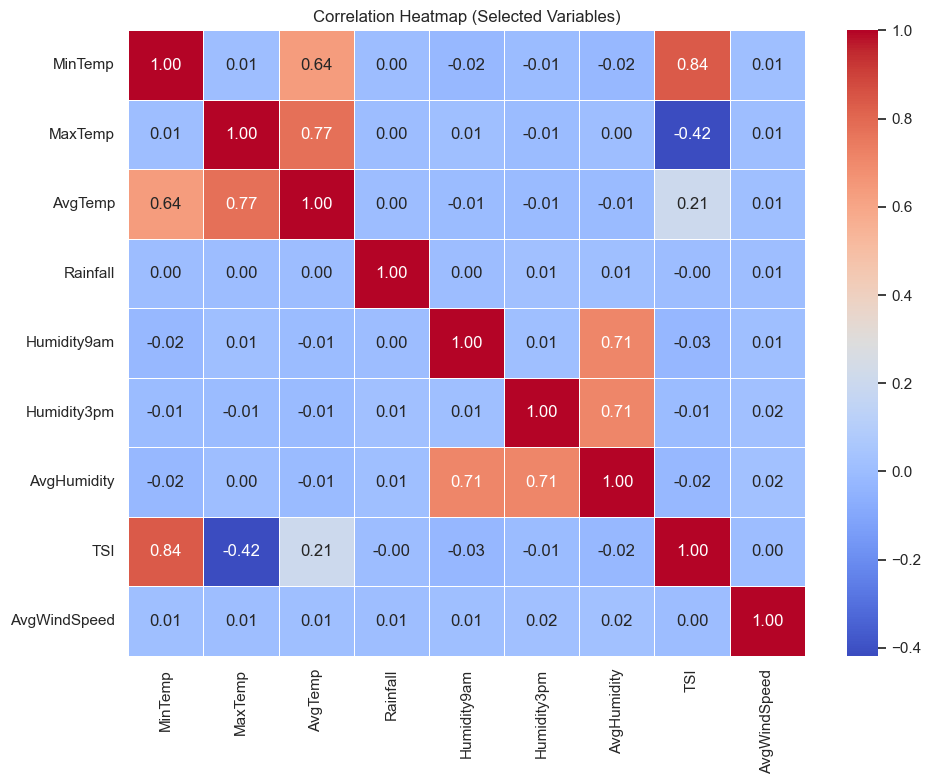

In [16]:
numeric_cols = df.select_dtypes(include=['number']).columns
corr_subset = ['MinTemp','MaxTemp','AvgTemp','Rainfall','Humidity9am',
               'Humidity3pm','AvgHumidity','TSI','AvgWindSpeed']
corr_subset = [c for c in corr_subset if c in numeric_cols]

corr = df[corr_subset].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap (Selected Variables)")
plt.tight_layout()
plt.show()

In [17]:
OUTPUT_DIR = Path("weather_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

df.to_csv(OUTPUT_DIR/"weather_enriched_daily.csv", index=False)
weekly_df.to_csv(OUTPUT_DIR/"weather_weekly.csv", index=False)
monthly_df.to_csv(OUTPUT_DIR/"weather_monthly.csv", index=False)
seasonal_df.to_csv(OUTPUT_DIR/"weather_seasonal.csv", index=False)
dow_df.to_csv(OUTPUT_DIR/"weather_dayofweek.csv", index=False)

# (Optional) Parquet for efficiency
df.to_parquet(OUTPUT_DIR/"weather_enriched_daily.parquet", index=False)

print("Exports written to:", OUTPUT_DIR.resolve())

Exports written to: C:\Users\raju\00-IndustrySeminars\weather_outputs


In [18]:
def filter_data(data: pd.DataFrame,
                years=None, months=None, seasons=None,
                rainy_mode="all", weekend_mode="all") -> pd.DataFrame:
    """
    rainy_mode: 'all' | 'rainy' | 'dry'
    weekend_mode: 'all' | 'weekdays' | 'weekends'
    """
    d = data.copy()
    if years:
        d = d[d['Year'].isin(years)]
    if months:
        d = d[d['Month'].isin(months)]
    if seasons:
        d = d[d['Season'].isin(seasons)]
    if rainy_mode == "rainy":
        d = d[d['IsRainy']]
    elif rainy_mode == "dry":
        d = d[~d['IsRainy']]
    if weekend_mode == "weekdays":
        d = d[~d['IsWeekend']]
    elif weekend_mode == "weekends":
        d = d[d['IsWeekend']]
    return d

# Example: KPIs for Summer months (June–Aug)
summer_filtered = filter_data(df, months=[6,7,8])
compute_global_kpis(summer_filtered)


{'AverageTemperature_C': 17.97854927225006,
 'RainfallIntensity_mm_per_day': 3.4805535671677403,
 'HumidityVariation_avg_pct_points': 26.592698639942736,
 'TemperatureStabilityIndex_mean': 0.6410564518876144,
 'WindSpeedTrend_mean_kmh': 16.042316869482224,
 'RainyDayPercent': 98.63994273443092}

# Streamlit App

In [19]:
#!apt-get install -y nodejs npm

In [20]:
#!pip install streamlit pandas matplotlib seaborn plotly windrose

In [21]:
#!npm install -g localtunnel

In [22]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# ------------------------------------------------------------------
# PAGE CONFIG
# ------------------------------------------------------------------
st.set_page_config(layout="wide", page_title="Weather Dashboard", page_icon="☁️")

# ------------------------------------------------------------------
# THEME & METRIC CARD STYLES (Dark + Colored KPI Tiles)
# ------------------------------------------------------------------
st.markdown("""
<style>
/* Base dark environment */
html, body, [data-testid="stAppViewContainer"] {
    background: #0d1117;
    color: #dce3ec;
    font-family: "Inter", "Segoe UI", system-ui, sans-serif;
}
.stTabs [role="tablist"] button[role="tab"][aria-selected="true"] {
    border-bottom: 3px solid #ec6b2d !important;
}

/* Metric tiles */
div[data-testid="stMetric"] {
    background: linear-gradient(135deg, var(--grad-a, #1e2530), var(--grad-b, #161b22));
    border: 1px solid #2a313c;
    border-radius: 16px;
    padding: 14px 18px 12px 18px;
    position: relative;
    overflow: hidden;
    box-shadow: 0 2px 4px rgba(0,0,0,0.45);
    transition: all .18s ease;
    min-height: 110px;
}
div[data-testid="stMetric"]::after {
    content:"";
    position:absolute;
    inset:0;
    background: radial-gradient(circle at 85% 15%, rgba(255,255,255,0.18), transparent 60%);
    opacity:.18;
    mix-blend-mode: overlay;
    pointer-events:none;
}
div[data-testid="stMetric"]:hover {
    border-color:#3d4754;
    box-shadow:0 4px 14px -2px rgba(0,0,0,0.55);
    transform:translateY(-2px);
}

/* Metric label */
div[data-testid="stMetric"] label {
    font-size: .70rem;
    letter-spacing:.08em;
    text-transform: uppercase;
    font-weight:600;
    color:#9fb1c2 !important;
    opacity:.95;
    margin-bottom:2px;
}
/* Metric value */
div[data-testid="stMetric"] [data-testid="stMetricValue"] {
    font-size: 1.65rem;
    font-weight:600;
    line-height:1.15;
    color: var(--value-color, #ffffff);
    text-shadow:0 0 6px rgba(0,0,0,0.4);
}
/* Delta (future use) */
div[data-testid="stMetric"] [data-testid="stMetricDelta"] {
    font-size:.75rem;
    font-weight:600;
}

/* Palette assignment by order per row (using hidden marker divs) */
.kpi-row.first  + div div[data-testid="stMetric"]:nth-of-type(1) { --grad-a:#1e3a8a; --grad-b:#172554; --value-color:#82cfff; }
.kpi-row.first  + div div[data-testid="stMetric"]:nth-of-type(2) { --grad-a:#581c87; --grad-b:#3b0a53; --value-color:#d8b4fe; }
.kpi-row.first  + div div[data-testid="stMetric"]:nth-of-type(3) { --grad-a:#92400e; --grad-b:#4a1d04; --value-color:#ffcb6b; }
.kpi-row.first  + div div[data-testid="stMetric"]:nth-of-type(4) { --grad-a:#7f1d1d; --grad-b:#471010; --value-color:#ffb4a2; }

.kpi-row.second + div div[data-testid="stMetric"]:nth-of-type(1) { --grad-a:#064e3b; --grad-b:#022c22; --value-color:#6ee7b7; }
.kpi-row.second + div div[data-testid="stMetric"]:nth-of-type(2) { --grad-a:#312e81; --grad-b:#11103a; --value-color:#a5b4fc; }
.kpi-row.second + div div[data-testid="stMetric"]:nth-of-type(3) { --grad-a:#024059; --grad-b:#021d29; --value-color:#7dd3fc; }
.kpi-row.second + div div[data-testid="stMetric"]:nth-of-type(4) { --grad-a:#701a36; --grad-b:#3a0d1d; --value-color:#f9a8d4; }

/* DataFrame header styling */
[data-testid="stDataFrame"] thead tr th {
    background:#18202a !important;
    color:#d0d6dc !important;
}

/* Scrollbars */
::-webkit-scrollbar { width: 10px; }
::-webkit-scrollbar-track { background: #11151a; }
::-webkit-scrollbar-thumb { background: #26303a; border-radius:8px; }
::-webkit-scrollbar-thumb:hover { background:#32404d; }
</style>
""", unsafe_allow_html=True)

# ------------------------------------------------------------------
# DATA LOADING & ENRICHMENT
# ------------------------------------------------------------------
@st.cache_data
def load_data():
    df = pd.read_csv("Weather_EDA_V2.0.csv")
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date')
    df['Year']      = df['Date'].dt.year
    df['Month']     = df['Date'].dt.month
    df['MonthName'] = df['Date'].dt.month_name()
    df['Day']       = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.day_name()
    df['WeekNum']   = df['Date'].dt.isocalendar().week

    season_map_std = {12:'Winter',1:'Winter',2:'Winter',
                      3:'Spring',4:'Spring',5:'Spring',
                      6:'Summer',7:'Summer',8:'Summer',
                      9:'Autumn',10:'Autumn',11:'Autumn'}
    df['Season'] = df['Month'].map(season_map_std)

    df['IsRainy']   = df['Rainfall'] > 0
    df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday','Sunday'])

    df['AvgTemp']           = (df['MinTemp'] + df['MaxTemp']) / 2
    df['AvgHumidity']       = (df['Humidity9am'] + df['Humidity3pm']) / 2
    df['HumidityVariation'] = (df['Humidity3pm'] - df['Humidity9am']).abs()

    denom = (df['MaxTemp'].abs() + df['MinTemp'].abs())
    df['TSI'] = 1 - (df['MaxTemp'] - df['MinTemp']).abs() / denom.replace(0, np.nan)
    df['TSI'] = df['TSI'].clip(0, 1)

    if {'WindSpeed9am','WindSpeed3pm'}.issubset(df.columns):
        df['AvgWindSpeed'] = df[['WindSpeed9am','WindSpeed3pm']].mean(axis=1)
    elif 'WindSpeed3pm' in df.columns:
        df['AvgWindSpeed'] = df['WindSpeed3pm']
    elif 'WindSpeed9am' in df.columns:
        df['AvgWindSpeed'] = df['WindSpeed9am']
    else:
        df['AvgWindSpeed'] = np.nan

    df['AvgTemp_7d']  = df['AvgTemp'].rolling(7, min_periods=3).mean()
    df['Rain_7d_Sum'] = df['Rainfall'].rolling(7, min_periods=3).sum()
    return df

# ------------------------------------------------------------------
# AGGREGATIONS
# ------------------------------------------------------------------
def aggregate_by_week(df):
    week = (df.groupby(['Year','WeekNum'])
              .agg(MinTemp=('MinTemp','min'),
                   MaxTemp=('MaxTemp','max'),
                   AvgTemp=('AvgTemp','mean'),
                   Rainfall=('Rainfall','sum'),
                   RainfallPerDay=('Rainfall','mean'),
                   AvgHumidity=('AvgHumidity','mean'),
                   HumidityVar=('HumidityVariation','mean'),
                   TSI=('TSI','mean'),
                   AvgWindSpeed=('AvgWindSpeed','mean'),
                   RainyDays=('IsRainy','sum'),
                   TotalDays=('IsRainy','count'),
                   Date=('Date','first'))
              .reset_index())
    week['RainyDayPct'] = 100 * week['RainyDays'] / week['TotalDays']
    week['TimeLabel']   = week['Date'].dt.strftime('%Y-W%W')
    return week

def aggregate_by_month(df):
    month = (df.groupby(['Year','Month'])
               .agg(MinTemp=('MinTemp','min'),
                    MaxTemp=('MaxTemp','max'),
                    AvgTemp=('AvgTemp','mean'),
                    Rainfall=('Rainfall','sum'),
                    RainfallPerDay=('Rainfall','mean'),
                    AvgHumidity=('AvgHumidity','mean'),
                    HumidityVar=('HumidityVariation','mean'),
                    TSI=('TSI','mean'),
                    AvgWindSpeed=('AvgWindSpeed','mean'),
                    RainyDays=('IsRainy','sum'),
                    TotalDays=('IsRainy','count'),
                    Date=('Date','first'))
               .reset_index())
    month['RainyDayPct']  = 100 * month['RainyDays'] / month['TotalDays']
    month['MonthYear']    = month['Date'].dt.strftime('%b %Y')
    month['TimeLabel']    = month['MonthYear']
    return month

def aggregate_by_season(df):
    season = (df.groupby(['Year','Season'])
                .agg(AvgTemp=('AvgTemp','mean'),
                     Rainfall=('Rainfall','sum'),
                     RainfallPerDay=('Rainfall','mean'),
                     AvgHumidity=('AvgHumidity','mean'),
                     HumidityVar=('HumidityVariation','mean'),
                     TSI=('TSI','mean'),
                     AvgWindSpeed=('AvgWindSpeed','mean'),
                     RainyDays=('IsRainy','sum'),
                     TotalDays=('IsRainy','count'))
                .reset_index())
    season['RainyDayPct'] = 100 * season['RainyDays'] / season['TotalDays']
    return season

# ------------------------------------------------------------------
# VISUALIZATIONS
# ------------------------------------------------------------------
def plot_wind_polar(wind_data, wind_dir_column, wind_speed_column, title="Wind Direction & Speed"):
    valid = wind_data.dropna(subset=[wind_dir_column, wind_speed_column])
    if len(valid) < 10:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.text(0.5, 0.5, 'Insufficient wind data', ha='center', va='center', transform=ax.transAxes)
        return fig
    counts = valid[wind_dir_column].value_counts()
    speed_by_dir = valid.groupby(wind_dir_column)[wind_speed_column].mean()
    fig, ax = plt.subplots(figsize=(9,5))
    bars = ax.bar(counts.index, counts.values, alpha=0.85)
    speeds = [speed_by_dir.get(d, 0) for d in counts.index]
    norm = plt.Normalize(min(speeds), max(speeds) if max(speeds)>0 else 1)
    colors = plt.cm.viridis(norm(speeds))
    for b, c in zip(bars, colors): b.set_color(c)
    ax.set_title(title); ax.set_xlabel("Wind Direction"); ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=45)
    if speeds:
        ax.text(0.99, 0.02, f"Speed Range: {min(speeds):.1f}-{max(speeds):.1f}",
                ha='right', va='bottom', transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig

def plot_temp_trends(data, time_col):
    fig = go.Figure()
    if 'AvgTemp' in data:
        fig.add_trace(go.Scatter(x=data[time_col], y=data['AvgTemp'],
                                 mode='lines', name='Avg Temp', line=dict(width=2)))
    if {'MinTemp','MaxTemp'}.issubset(data.columns):
        fig.add_trace(go.Scatter(x=data[time_col], y=data['MinTemp'],
                                 mode='lines', name='Min Temp', line=dict(width=1)))
        fig.add_trace(go.Scatter(x=data[time_col], y=data['MaxTemp'],
                                 mode='lines', name='Max Temp', line=dict(width=1)))
    if 'AvgTemp_7d' in data.columns and data['AvgTemp_7d'].notna().sum() > 5:
        fig.add_trace(go.Scatter(x=data[time_col], y=data['AvgTemp_7d'],
                                 mode='lines', name='7d Avg Temp', line=dict(dash='dot', width=2)))
    fig.update_layout(title='Temperature Trends',
                      xaxis_title='Time Period', yaxis_title='Temperature (°C)',
                      height=420, margin=dict(l=10,r=10,t=50,b=10),
                      legend=dict(orientation='h', y=1.03, x=1, xanchor='right'),
                      template='plotly_dark')
    return fig

def plot_rainfall(data, time_col):
    fig = px.bar(data, x=time_col, y='Rainfall',
                 title='Rainfall (Sum)', labels={'Rainfall':'Rainfall (mm)'},
                 color='Rainfall', color_continuous_scale='Blues')
    if 'Rain_7d_Sum' in data.columns and data['Rain_7d_Sum'].notna().sum() > 5:
        fig2 = px.line(data, x=time_col, y='Rain_7d_Sum')
        for t in fig2.data:
            t.name = '7d Rain Sum'
            t.line.width = 2
            fig.add_trace(t)
    fig.update_layout(height=420, margin=dict(l=10,r=10,t=50,b=10),
                      coloraxis_showscale=False, template='plotly_dark')
    return fig

def plot_humidity_boxplot(df, group_col):
    hdf = df[[group_col, 'Humidity9am', 'Humidity3pm']].melt(
        id_vars=group_col, value_vars=['Humidity9am','Humidity3pm'],
        var_name='Time', value_name='Humidity')
    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(x=group_col, y='Humidity', hue='Time', data=hdf,
                palette='pastel', ax=ax)
    ax.set_title('Humidity Variation Distribution')
    ax.set_ylabel('Humidity (%)')
    for label in ax.get_xticklabels(): label.set_rotation(45)
    ax.legend(title='Time of Day')
    fig.tight_layout()
    return fig

def detect_outliers(df, cols):
    out = {}
    for c in cols:
        if pd.api.types.is_numeric_dtype(df[c]):
            Q1, Q3 = df[c].quantile([0.25,0.75])
            IQR = Q3-Q1
            lb, ub = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            out[c] = ((df[c]<lb)|(df[c]>ub)).sum()
    return out

# Spell metrics
def longest_consecutive(mask_series):
    run = max_run = 0
    for v in mask_series:
        if v:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run
def spell_metrics(df):
    dry = (df['Rainfall'] == 0)
    wet = (df['Rainfall'] > 0)
    return {
        "Longest Dry Spell": longest_consecutive(dry),
        "Longest Wet Spell": longest_consecutive(wet)
    }

# ------------------------------------------------------------------
# MAIN
# ------------------------------------------------------------------
def main():
    st.title("Weather Dashboard & EDA Tool")
    with st.spinner("Loading weather data..."):
        df = load_data()

    tab_dashboard, tab_eda = st.tabs(["Dashboard", "EDA & Analysis"])

    # ===================== DASHBOARD =====================
    with tab_dashboard:
        st.sidebar.header("Filters")

        time_agg = st.sidebar.radio("Time Aggregation", ["Daily","Weekly","Monthly"], index=0)

        years = sorted(df['Year'].dropna().unique())
        selected_years = st.sidebar.multiselect("Select Years",
                                                years,
                                                default=years[-5:] if len(years)>5 else years)
        filtered = df[df['Year'].isin(selected_years)] if selected_years else df.copy()

        seasons = sorted(filtered['Season'].dropna().unique())
        selected_seasons = st.sidebar.multiselect("Select Seasons", seasons, default=[])
        if selected_seasons:
            filtered = filtered[filtered['Season'].isin(selected_seasons)]

        if time_agg in ("Daily","Weekly"):
            months = sorted(filtered['Month'].unique())
            month_names = [datetime(2000,m,1).strftime('%B') for m in months]
            selected_month_names = st.sidebar.multiselect("Select Months", month_names, default=[])
            if selected_month_names:
                sel_month_nums = [datetime.strptime(m,'%B').month for m in selected_month_names]
                filtered = filtered[filtered['Month'].isin(sel_month_nums)]

        rain_filter = st.sidebar.radio("Precipitation Filter",
                                       ["All Days","Rainy Days Only","Dry Days Only"], index=0)
        if rain_filter == "Rainy Days Only":
            filtered = filtered[filtered['IsRainy']]
        elif rain_filter == "Dry Days Only":
            filtered = filtered[~filtered['IsRainy']]

        if 'WindDir3pm' in filtered.columns:
            wind_dirs = sorted(filtered['WindDir3pm'].dropna().unique())
            selected_wdirs = st.sidebar.multiselect("Wind Direction (3pm)", wind_dirs, default=[])
            if selected_wdirs:
                filtered = filtered[filtered['WindDir3pm'].isin(selected_wdirs)]

        weekend_opt = st.sidebar.selectbox("Weekend Filter",
                                           ["All","Weekdays Only","Weekends Only"], index=0)
        if weekend_opt == "Weekdays Only":
            filtered = filtered[~filtered['IsWeekend']]
        elif weekend_opt == "Weekends Only":
            filtered = filtered[filtered['IsWeekend']]

        if time_agg == "Weekly":
            display_df = aggregate_by_week(filtered); time_col = 'TimeLabel'
        elif time_agg == "Monthly":
            display_df = aggregate_by_month(filtered); time_col = 'TimeLabel'
        else:
            display_df = filtered.copy(); display_df['TimeLabel'] = display_df['Date']; time_col = 'TimeLabel'

        if len(display_df)==0:
            st.warning("No data for selected filters.")
            return

        # KPI ROWS --------------------------------------------------
        st.subheader("Key Weather Metrics")

        # Hidden markers for CSS palette scoping
        st.markdown('<div class="kpi-row first"></div>', unsafe_allow_html=True)

        row1 = st.columns(4)
        with row1[0]:
            avg_temp = display_df['AvgTemp'].mean()
            st.metric("Average Temperature", f"{avg_temp:.1f}°C")
        with row1[1]:
            rainy_days = display_df['IsRainy'].sum() if 'IsRainy' in display_df.columns else (
                display_df['RainyDays'].sum() if 'RainyDays' in display_df.columns else 0)
            if time_agg == "Daily":
                rain_pct = (rainy_days / len(display_df))*100 if len(display_df) else 0
            else:
                total_days = display_df['TotalDays'].sum() if 'TotalDays' in display_df.columns else len(display_df)
                rain_pct = (rainy_days / total_days)*100 if total_days>0 else 0
            st.metric("Rainy Days (%)", f"{int(rainy_days)} ({rain_pct:.1f}%)")
        with row1[2]:
            avg_humidity = display_df['AvgHumidity'].mean() if 'AvgHumidity' in display_df else filtered['AvgHumidity'].mean()
            st.metric("Average Humidity", f"{avg_humidity:.1f}%")
        with row1[3]:
            total_rain = display_df['Rainfall'].sum()
            st.metric("Total Rainfall", f"{total_rain:.1f} mm")

        st.markdown('<div class="kpi-row second"></div>', unsafe_allow_html=True)

        row2 = st.columns(4)
        with row2[0]:
            st.metric("Temp Stability Index (TSI)", f"{display_df['TSI'].mean():.3f}")
        with row2[1]:
            hv = display_df['HumidityVar'].mean() if 'HumidityVar' in display_df else filtered['HumidityVariation'].mean()
            st.metric("Humidity Variation (avg Δ%)", f"{hv:.1f}")
        with row2[2]:
            st.metric("Avg Wind Speed", f"{display_df['AvgWindSpeed'].mean():.1f} km/h")
        with row2[3]:
            rainfall_intensity = (display_df['Rainfall'].sum() /
                                  display_df['TotalDays'].sum()) if 'TotalDays' in display_df else display_df['Rainfall'].mean()
            st.metric("Rainfall Intensity (mm/day)", f"{rainfall_intensity:.2f}")

        # CHARTS ----------------------------------------------------
        st.subheader("Temperature Trends")
        st.plotly_chart(plot_temp_trends(display_df, time_col), use_container_width=True)

        c1, c2 = st.columns(2)
        with c1:
            st.subheader("Rainfall")
            st.plotly_chart(plot_rainfall(display_df, time_col), use_container_width=True)
        with c2:
            st.subheader("Humidity Variation Distribution")
            if time_agg == "Monthly":
                group_col = 'MonthYear'
            elif time_agg == "Weekly":
                group_col = 'TimeLabel'
            else:
                group_col = 'MonthName'
            if time_agg == "Daily" and filtered[group_col].nunique() > 12:
                st.info("Too many groups; refine filters for boxplot.")
            else:
                st.pyplot(plot_humidity_boxplot(filtered, group_col))

        st.subheader("Wind Patterns")
        w1, w2 = st.columns(2)
        with w1:
            if time_agg == "Daily":
                st.write("Wind: 9am")
                st.pyplot(plot_wind_polar(filtered, 'WindDir9am', 'WindSpeed9am',
                                          "Wind Direction & Speed (9am)"))
            else:
                st.info("Daily aggregation required for wind direction detail.")
        with w2:
            if time_agg == "Daily":
                st.write("Wind: 3pm")
                st.pyplot(plot_wind_polar(filtered, 'WindDir3pm', 'WindSpeed3pm',
                                          "Wind Direction & Speed (3pm)"))
            else:
                st.info("Daily aggregation required for wind direction detail.")

        # SEASONAL / DOW --------------------------------------------
        with st.expander("Seasonal & Day-of-Week KPIs"):
            seasonal_df = aggregate_by_season(filtered)
            st.markdown("**Seasonal Summary**")
            st.dataframe(seasonal_df)

            dow = (filtered.groupby('DayOfWeek')
                           .agg(AvgTemp=('AvgTemp','mean'),
                                HumidityVar=('HumidityVariation','mean'),
                                AvgWind=('AvgWindSpeed','mean'),
                                Rainfall=('Rainfall','mean'))
                           .reset_index())
            weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
            dow['DayOfWeek'] = pd.Categorical(dow['DayOfWeek'], categories=weekday_order, ordered=True)
            st.markdown("**Average Metrics by Day of Week**")
            st.dataframe(dow.sort_values('DayOfWeek'))

            spells = spell_metrics(filtered)
            st.markdown("**Spell Metrics (Current Filter)**")
            st.write(spells)

        # DOWNLOADS -------------------------------------------------
        with st.expander("Downloads"):
            st.download_button("Download Filtered Daily Data (CSV)",
                               data=filtered.to_csv(index=False),
                               file_name="filtered_daily_weather.csv",
                               mime="text/csv")
            if time_agg == "Weekly":
                st.download_button("Download Weekly Aggregation (CSV)",
                                   data=display_df.to_csv(index=False),
                                   file_name="weekly_weather.csv",
                                   mime="text/csv")
            if time_agg == "Monthly":
                st.download_button("Download Monthly Aggregation (CSV)",
                                   data=display_df.to_csv(index=False),
                                   file_name="monthly_weather.csv",
                                   mime="text/csv")
            st.download_button("Download Seasonal Aggregation (CSV)",
                               data=aggregate_by_season(filtered).to_csv(index=False),
                               file_name="seasonal_weather.csv",
                               mime="text/csv")

    # ===================== EDA TAB =====================
    with tab_eda:
        st.header("Exploratory Data Analysis")
        eda_df = df.copy()

        st.subheader("Data Overview")
        o1, o2 = st.columns(2)
        with o1:
            st.write(f"**Dataset Size:** {eda_df.shape[0]} rows × {eda_df.shape[1]} columns")
            st.write(f"**Date Range:** {eda_df['Date'].min().strftime('%d %b %Y')} → "
                     f"{eda_df['Date'].max().strftime('%d %b %Y')}")
        with o2:
            missing = eda_df.isnull().sum()
            miss_df = (pd.DataFrame({'Missing Values': missing,
                                     'Percent': (missing/len(eda_df))*100})
                       .query('`Missing Values`>0')
                       .sort_values('Missing Values', ascending=False)
                       .head(5))
            st.write("**Top 5 Columns with Missing Values:**")
            st.dataframe(miss_df)

        st.subheader("Correlation Heatmap")
        numeric_df = eda_df.select_dtypes(include=['number'])
        default_corr_cols = [c for c in ['MinTemp','MaxTemp','Rainfall','Humidity9am',
                                         'Humidity3pm','Pressure9am','Pressure3pm','AvgWindSpeed']
                             if c in numeric_df.columns]
        corr_features = st.multiselect("Select features:", numeric_df.columns.tolist(),
                                       default=default_corr_cols)
        if corr_features:
            corr = numeric_df[corr_features].corr()
            fig, ax = plt.subplots(figsize=(10,8))
            sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", ax=ax)
            ax.set_title("Correlation Heatmap")
            st.pyplot(fig)

            corr_flat = (corr.unstack()
                             .reset_index()
                             .rename(columns={'level_0':'Feature 1','level_1':'Feature 2',0:'Correlation'}))
            corr_flat = corr_flat[corr_flat['Feature 1'] != corr_flat['Feature 2']]
            corr_sorted = corr_flat.sort_values('Correlation', ascending=False)
            cc1, cc2 = st.columns(2)
            with cc1:
                st.write("**Top 5 Positive**")
                st.dataframe(corr_sorted.head(5))
            with cc2:
                st.write("**Top 5 Negative**")
                st.dataframe(corr_sorted.tail(5))

        st.subheader("Distribution Analysis")
        dist_feature = st.selectbox("Feature:", numeric_df.columns.tolist(),
                                    index=(numeric_df.columns.tolist().index('AvgTemp')
                                           if 'AvgTemp' in numeric_df.columns else 0))
        fig, ax = plt.subplots(figsize=(10,6))
        sns.histplot(numeric_df[dist_feature].dropna(), kde=True, ax=ax)
        ax.set_title(f"Distribution: {dist_feature}")
        st.pyplot(fig)
        st.write("**Descriptive Statistics**")
        st.dataframe(numeric_df[dist_feature].describe())

        st.subheader("Outlier Detection (IQR)")
        outlier_cols = st.multiselect("Columns:", numeric_df.columns.tolist(),
                                      default=[c for c in ['MinTemp','MaxTemp','Rainfall','WindGustSpeed']
                                               if c in numeric_df.columns])
        if outlier_cols:
            detected = detect_outliers(eda_df, outlier_cols)
            out_df = (pd.DataFrame({'Column': list(detected.keys()),
                                    'Outlier Count': list(detected.values())})
                      .sort_values('Outlier Count', ascending=False))
            fig2 = px.bar(out_df, x='Column', y='Outlier Count',
                          title='Outliers per Column',
                          color='Outlier Count', text_auto=True,
                          template='plotly_dark')
            st.plotly_chart(fig2, use_container_width=True)

            chosen = st.selectbox("Boxplot column:", outlier_cols)
            fig3, ax3 = plt.subplots(figsize=(8,5))
            sns.boxplot(y=eda_df[chosen], ax=ax3)
            ax3.set_title(f"Boxplot: {chosen}")
            st.pyplot(fig3)

        st.subheader("Monthly Time Series (Aggregated)")
        ts_df = (df
                 .groupby(pd.Grouper(key='Date', freq='M'))
                 .agg(MinTemp=('MinTemp','mean'),
                      MaxTemp=('MaxTemp','mean'),
                      Rainfall=('Rainfall','sum'),
                      Humidity9am=('Humidity9am','mean'),
                      Humidity3pm=('Humidity3pm','mean'),
                      AvgWindSpeed=('AvgWindSpeed','mean'))
                 .reset_index())
        ts_metric = st.selectbox("Timeseries Metric:",
                                 [c for c in ['MinTemp','MaxTemp','Rainfall','Humidity9am',
                                              'Humidity3pm','AvgWindSpeed'] if c in ts_df.columns])
        ts_fig = px.line(ts_df, x='Date', y=ts_metric,
                         title=f"Monthly {ts_metric} Over Time",
                         template='plotly_dark')
        st.plotly_chart(ts_fig, use_container_width=True)

# ------------------------------------------------------------------
if __name__ == "__main__":
    main()

Overwriting app.py


In [ ]:
! streamlit run app.py